<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/trained_networks_comparison_to_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: complete_dataset/Images/4655.png  
  inflating: complete_dataset/Images/13432.png  
  inflating: complete_dataset/Images/13393.png  
  inflating: complete_dataset/Images/14645.png  
  inflating: complete_dataset/Images/16896.png  
  inflating: complete_dataset/Images/4638.png  
  inflating: complete_dataset/Images/12695.png  
  inflating: complete_dataset/Images/13074.png  
  inflating: complete_dataset/Images/16020.png  
  inflating: complete_dataset/Images/15454.png  
  inflating: complete_dataset/Images/690.png  
  inflating: complete_dataset/Images/8168.png  
  inflating: complete_dataset/Images/4244.png  
  inflating: complete_dataset/Images/16078.png  
  inflating: complete_dataset/Images/6062.png  
  inflating: complete_dataset/Images/7468.png  
  inflating: complete_dataset/Images/1326.png  
  inflating: complete_dataset/Images/2106.png  
  inflating: complete_dataset/Images/585.png  
  inflating: complete_dataset/

In [40]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    data_parse = data.split('}')[:-1]
    for d in data_parse:
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
array_imgs = get_images(images_curve, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)
array_annotations = parse_json(data_curve, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA

split_test_train_value = 0.30
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=0.30, random_state=42)
# FOR LSTMs -> suffle=False because the order of images is relevant
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_imgs, array_annotations, test_size=split_test_train_value, random_state=42, shuffle=False)
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_2_images, array_annotations, test_size=0.30, random_state=42)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

print(annotations_train[0])
print(annotations_train.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)


['/content/complete_dataset/Images/1342.png', '/content/complete_dataset/Images/2644.png', '/content/complete_dataset/Images/1781.png', '/content/complete_dataset/Images/12019.png', '/content/complete_dataset/Images/384.png', '/content/complete_dataset/Images/6186.png', '/content/complete_dataset/Images/7322.png', '/content/complete_dataset/Images/10781.png', '/content/complete_dataset/Images/375.png', '/content/complete_dataset/Images/7417.png', '/content/complete_dataset/Images/10485.png', '/content/complete_dataset/Images/12657.png', '/content/complete_dataset/Images/7431.png', '/content/complete_dataset/Images/14691.png', '/content/complete_dataset/Images/7166.png', '/content/complete_dataset/Images/12233.png', '/content/complete_dataset/Images/12493.png', '/content/complete_dataset/Images/12371.png', '/content/complete_dataset/Images/9474.png', '/content/complete_dataset/Images/9824.png', '/content/complete_dataset/Images/6880.png', '/content/complete_dataset/Images/595.png', '/co

In [2]:
!ls "/content/drive/My Drive"
!unzip "/content/drive/My Drive/many_curves_dataset.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [5]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('many_curves_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_many_curves = np.stack(array_imgs, axis=0)
annotations_many_curves = np.stack(array_annotations, axis=0)

print(images_many_curves.shape)
print(annotations_many_curves.shape)

['/content/many_curves_dataset/1342.png', '/content/many_curves_dataset/2644.png', '/content/many_curves_dataset/1781.png', '/content/many_curves_dataset/384.png', '/content/many_curves_dataset/375.png', '/content/many_curves_dataset/595.png', '/content/many_curves_dataset/1714.png', '/content/many_curves_dataset/2558.png', '/content/many_curves_dataset/1658.png', '/content/many_curves_dataset/2633.png', '/content/many_curves_dataset/2175.png', '/content/many_curves_dataset/2652.png', '/content/many_curves_dataset/1935.png', '/content/many_curves_dataset/2635.png', '/content/many_curves_dataset/2021.png', '/content/many_curves_dataset/1538.png', '/content/many_curves_dataset/2072.png', '/content/many_curves_dataset/447.png', '/content/many_curves_dataset/1025.png', '/content/many_curves_dataset/1374.png', '/content/many_curves_dataset/593.png', '/content/many_curves_dataset/2106.png', '/content/many_curves_dataset/2702.png', '/content/many_curves_dataset/2626.png', '/content/many_curve

In [6]:
!ls "/content/drive/My Drive"
!unzip "/content/drive/My Drive/simple_circuit_dataset.zip"

 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [7]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    for name in list_images:
        img = cv2.imread(name)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        array_imgs.append(img)

    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('simple_circuit_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
# normalized_Y = normalize(array_annotations_w)
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_simple = np.stack(array_imgs, axis=0)
annotations_simple = np.stack(array_annotations, axis=0)

print(images_simple.shape)
print(annotations_simple.shape)

['/content/simple_circuit_dataset/1342.png', '/content/simple_circuit_dataset/384.png', '/content/simple_circuit_dataset/375.png', '/content/simple_circuit_dataset/595.png', '/content/simple_circuit_dataset/1714.png', '/content/simple_circuit_dataset/1658.png', '/content/simple_circuit_dataset/1538.png', '/content/simple_circuit_dataset/447.png', '/content/simple_circuit_dataset/1025.png', '/content/simple_circuit_dataset/1374.png', '/content/simple_circuit_dataset/593.png', '/content/simple_circuit_dataset/598.png', '/content/simple_circuit_dataset/1293.png', '/content/simple_circuit_dataset/1698.png', '/content/simple_circuit_dataset/1710.png', '/content/simple_circuit_dataset/453.png', '/content/simple_circuit_dataset/933.png', '/content/simple_circuit_dataset/129.png', '/content/simple_circuit_dataset/557.png', '/content/simple_circuit_dataset/986.png', '/content/simple_circuit_dataset/97.png', '/content/simple_circuit_dataset/19.png', '/content/simple_circuit_dataset/864.png', '/c

In [8]:
from tensorflow import keras
print('--- DEEPEST LSTM TINYPILOTNET MODEL ---')
deepest_lstm_tinypilotnet = keras.models.load_model('/content/drive/My Drive/20210302-082208_deepest_lstm_tinypilotnet_model_300_RGB_sequence_patch.h5')

--- DEEPEST LSTM TINYPILOTNET MODEL ---


In [41]:
predictions_many_curves = deepest_lstm_tinypilotnet.predict(images_many_curves)
predictions_simple = deepest_lstm_tinypilotnet.predict(images_simple)
predictions_images_train = deepest_lstm_tinypilotnet.predict(images_train)
predictions_images_validation = deepest_lstm_tinypilotnet.predict(images_validation)

[ 0.6329553  -0.01344237]
[-0.01344237 -0.01344237 -0.01198795 ... -0.05879657 -0.06625445
 -0.10108183]
[0.41176471 0.26590405]
[ 0.26590405  0.25026264  0.25026264 ... -0.22747753 -0.23177308
 -0.24657406]


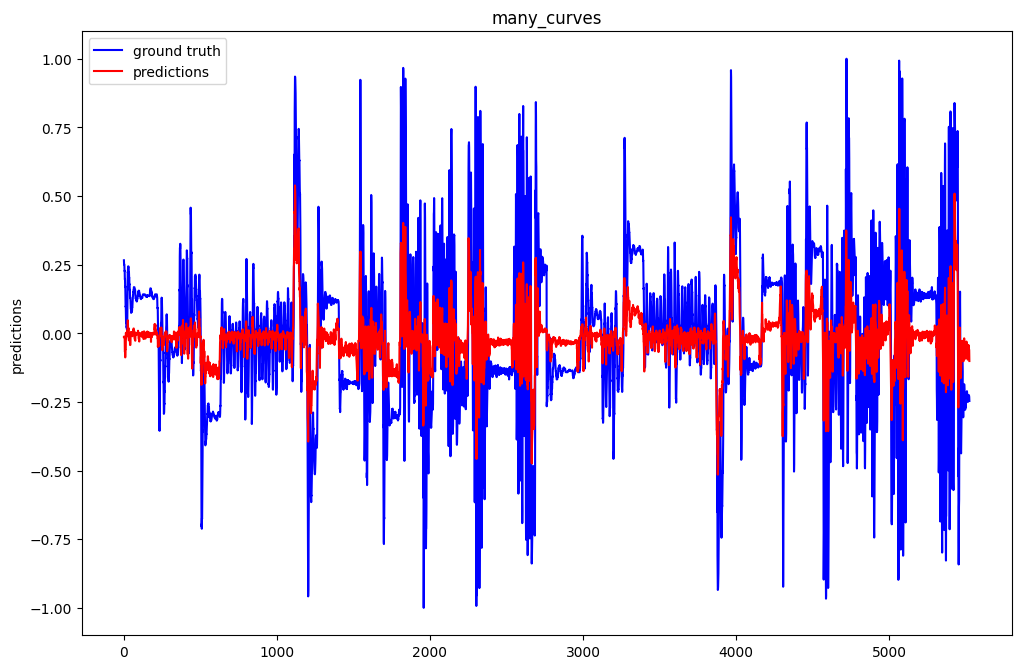

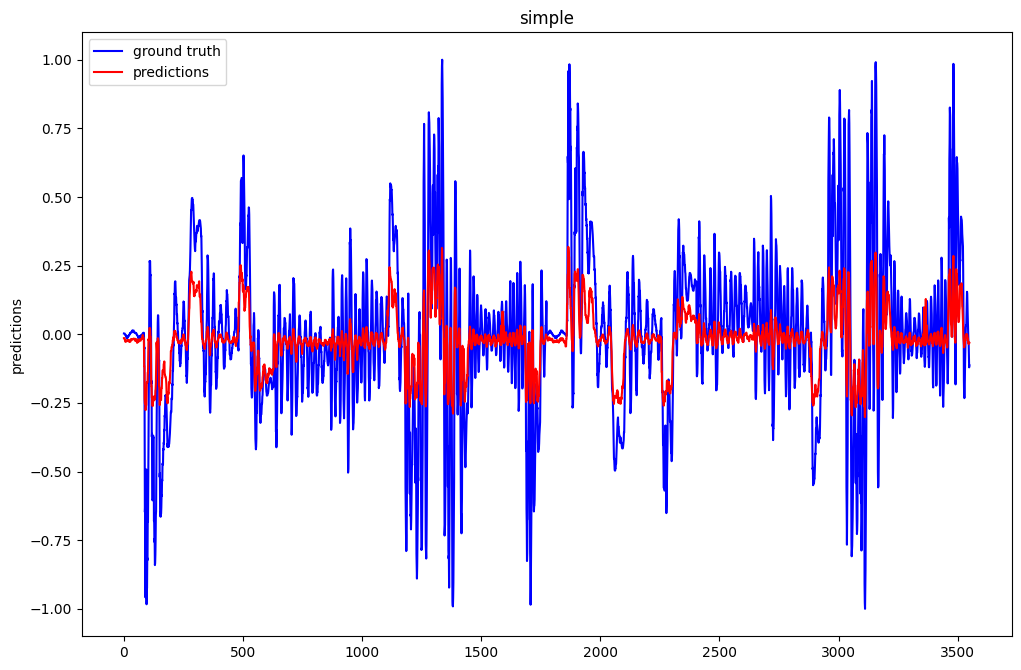

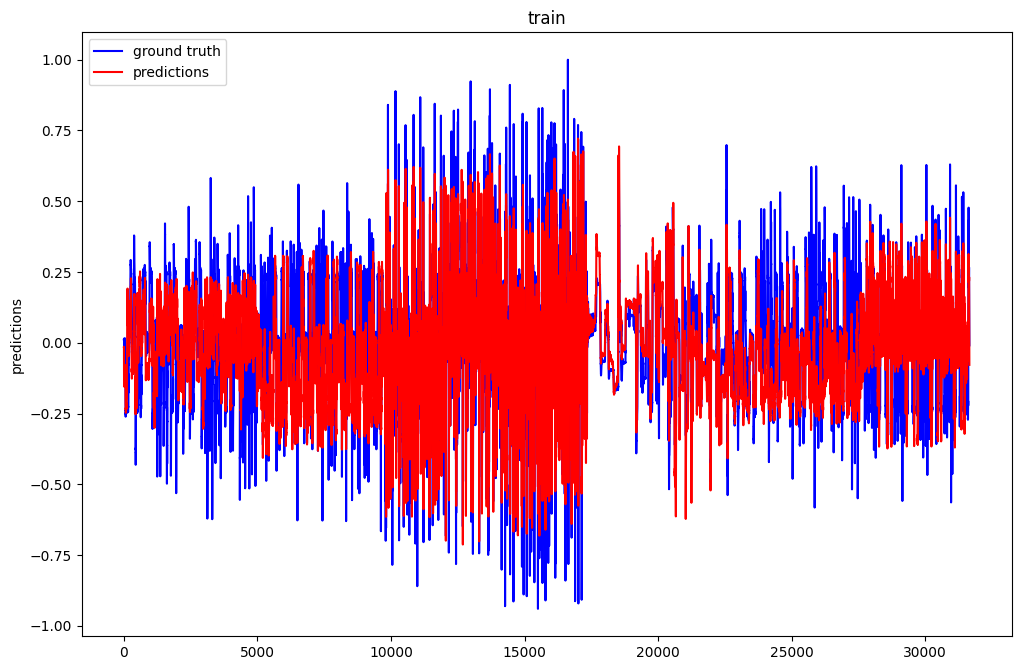

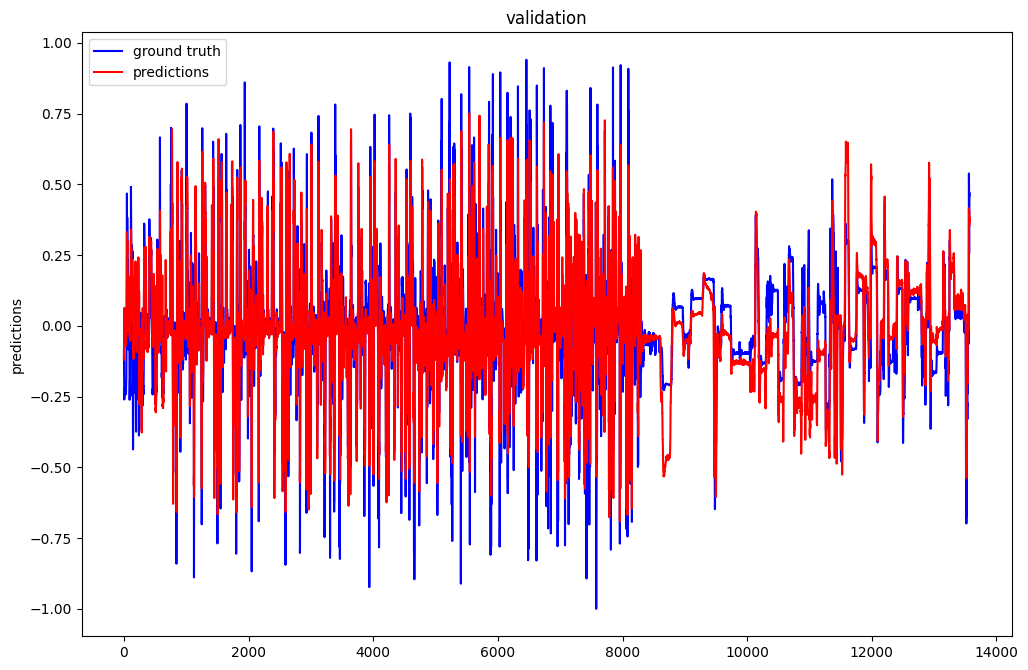

In [42]:
import matplotlib.pyplot as plt
print(predictions_many_curves[0])
print(predictions_many_curves[:,1])

print(annotations_many_curves[0])
print(annotations_many_curves[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_many_curves[:,1], "-b", label="ground truth")
plt.plot(predictions_many_curves[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('many_curves')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_simple[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('simple')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_images_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('train')
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
plt.plot(predictions_images_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('validation')
plt.show()